# Fisheries competition

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  The video states that vgg.py and ``vgg_ft()`` from utils.py have been updated to include VGG with batch normalization, but this is not the case.  We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method ``vgg_ft_bn()`` (which is already in utils.py) which we use in this notebook.

In [66]:
 import sys
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)

/home/ubuntu/anaconda2/bin/python
2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
sys.version_info(major=2, minor=7, micro=12, releaselevel='final', serial=0)


In [67]:
#from theano.sandbox import cuda
# omit the cude part
# esnure that the notebook has GPU enabled

%reload_ext autoreload
%autoreload 2

In [68]:

#! rm vgg16bn\ \(1\).py

In [69]:
! ls

data	       test.zip   utils.py   vgg16bn.py   vgg16.py
lesson7.ipynb  train.zip  utils.pyc  vgg16bn.pyc  vgg16.pyc


Commenting these out: since i am running this on AWS 

In [70]:
"""from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))"""

'from google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))'

Since we are building these off VGG  we'll need all the get up we used in L1+2+3

In [71]:
! pip install bcolz

You are using pip version 8.1.2, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [72]:
! pip install keras==1.2.2

You are using pip version 8.1.2, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
! pip install tensorflow==1.0.1

You are using pip version 8.1.2, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [74]:
%matplotlib inline
import utils; reload(utils)
from utils import *
# SKip importing the utils.. and see the code the hard way.. as you go..
from __future__ import division, print_function

In [75]:
#path = "data/fish/sample/"
path = "data/fish/"
#path = "content/data/fish/"
batch_size=28
# was 64 and that caused run time crashes

In [76]:
import requests
#https://ramhiser.com/2012/11/23/how-to-download-kaggle-data-with-python-and-requests-dot-py/

# The direct link to the Kaggle data set
data_url = 'https://www.kaggle.com/c/5568/download/train.zip'

# The local path where the data set is saved.
local_filename = "train.zip"

# Kaggle Username and Password
kaggle_info = {'UserName': "ronyroy", 'Password': "6cb90e9d97"}

# Attempts to download the CSV file. Gets rejected because we are not logged in.
r = requests.get(data_url)

# Login to Kaggle and retrieve the data.
#r = requests.post(r.url, data = kaggle_info, prefetch = False)
r = requests.post(r.url, data = kaggle_info, stream = False)

# Writes the data to a local file one chunk at a time.
f = open(local_filename, 'w')
for chunk in r.iter_content(chunk_size = 512 * 1024): # Reads 512KB at a time into memory
    if chunk: # filter out keep-alive new chunks
        f.write(chunk)
f.close()

The above convoluted process was adopted .. because the wget wasn't working.. :(

In [77]:
#! ls

In [78]:
import requests
#https://ramhiser.com/2012/11/23/how-to-download-kaggle-data-with-python-and-requests-dot-py/

# The direct link to the Kaggle data set
data_url = 'https://www.kaggle.com/c/5568/download/test_stg1.zip'

# The local path where the data set is saved.
local_filename = "test.zip"

# Kaggle Username and Password
kaggle_info = {'UserName': "ronyroy", 'Password': "6cb90e9d97"}

# Attempts to download the CSV file. Gets rejected because we are not logged in.
r = requests.get(data_url)

# Login to Kaggle and retrieve the data.
#r = requests.post(r.url, data = kaggle_info, prefetch = False)
r = requests.post(r.url, data = kaggle_info, stream = False)

# Writes the data to a local file one chunk at a time.
f = open(local_filename, 'w')
for chunk in r.iter_content(chunk_size = 512 * 1024): # Reads 512KB at a time into memory
    if chunk: # filter out keep-alive new chunks
        f.write(chunk)
f.close()

In [79]:
! mkdir data
! mkdir data/fish
! mkdir data/fish/test
! unzip test.zip -d data/fish/test
# notsure why it had to be this way... single line would have sufficed in a term

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/fish’: File exists
mkdir: cannot create directory ‘data/fish/test’: File exists
Archive:  test.zip
replace data/fish/test/test_stg1/img_00005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [80]:
! sudo apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-20ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 274 not upgraded.


In [81]:
! unzip train.zip -d data/fish

Archive:  train.zip
replace data/fish/train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [82]:
# get batches and get classes are in the utils.. 
# putting them here for analyiss of what it does..

def get_classes(path):
    batches = get_batches(path+'train', shuffle=False, batch_size=1)
    val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
    test_batches = get_batches(path+'test', shuffle=False, batch_size=1)
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
        val_batches.filenames, batches.filenames, test_batches.filenames)

  
  
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)



## These get bacthes run of cammoands are moved further down after the necessary folders were created

In [87]:
#batches = get_batches(path+'train', batch_size=batch_size)
#val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

#(val_classes, trn_classes, val_labels, trn_labels, 
  #  val_filenames, filenames, test_filenames) = get_classes(path)

Sometimes it's helpful to have just the filenames, without the path.

In [88]:
#raw_filenames = [f.split('/')[-1] for f in filenames]
#raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
#raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Setup dirs

you'll have to run these commands to set up the direcotries first..   
since the data is not readily available..   
and is procured by the convoluted means as described above..  

We create the validation and sample sets in the usual way.

In [89]:
%cd ~ # to ensure you are at home irrespective of what mumbo jumbo file operations you did before this.. :/
%cd data/fish
%cd train
%mkdir ../valid

[Errno 2] No such file or directory: '~ # to ensure you are at home irrespective of what mumbo jumbo file operations you did before this.. :/'
/home/ubuntu/nbs/data/fish/train
[Errno 2] No such file or directory: 'data/fish'
/home/ubuntu/nbs/data/fish/train
[Errno 2] No such file or directory: 'train'
/home/ubuntu/nbs/data/fish/train
mkdir: cannot create directory ‘../valid’: File exists


In [90]:
g = glob('*')
for d in g: os.mkdir('../valid/'+d)

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

OSError: [Errno 17] File exists: '../valid/DOL'

In [91]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

mkdir: cannot create directory ‘../sample’: File exists
mkdir: cannot create directory ‘../sample/train’: File exists
mkdir: cannot create directory ‘../sample/valid’: File exists


In [92]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)
# paths exist.. then good

OSError: [Errno 17] File exists: '../sample/train/DOL'

In [93]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/home/ubuntu/nbs/data/fish/valid
/home/ubuntu/nbs/data/fish


In [94]:
%mkdir results
%mkdir sample/results
%cd ../..

mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘sample/results’: File exists
/home/ubuntu/nbs


## Moving the get classes commands from higher up to down here.. 

In [95]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [96]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [97]:
def vgg_ft_bn(out_dim):
    vgg = Vgg16BN()
    vgg.ft(out_dim)
    model = vgg.model
    return model


In [98]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [99]:
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [100]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [101]:
test = get_data(path+'test')

Found 1000 images belonging to 1 classes.


In [102]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [103]:
save_array(path+'results/test.dat', test)

In [104]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [105]:
test = load_array(path+'results/test.dat')

In [106]:
gen = image.ImageDataGenerator()

In [107]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [108]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 91s - loss: 2.7818 - acc: 0.5056 - val_loss: 1.0335 - val_acc: 0.7480
Epoch 2/3
3277/3277 [==============================] - 91s - loss: 1.6449 - acc: 0.6460 - val_loss: 0.7464 - val_acc: 0.8320
Epoch 3/3
3277/3277 [==============================] - 92s - loss: 1.2647 - acc: 0.7144 - val_loss: 0.6496 - val_acc: 0.8480


In [109]:
model.save_weights(path+'results/ft1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers.   
(All following analysis will be done on just the pre-computed convolutional features.)

In [110]:
model.load_weights(path+'results/ft1.h5')

In [111]:
conv_layers,fc_layers = split_at(model, Convolution2D)

Split is a custom fn,, splits at the said layer  
Create a model with those conv layers  
conv_feat ures predic on train
conv_val_feat ures predict on val
conv_val_feat ures predict on test

In [112]:
conv_model = Sequential(conv_layers)

In [113]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [114]:
conv_test_feat = conv_model.predict(test)

use bcolz to save the predictions outputs above.. to the said files..   
This is the precompute the convolutional output .. stage

In [115]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [116]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [117]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [118]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [119]:
conv_val_feat.shape

(500, 512, 14, 14)

In [269]:
conv_test_feat.shape

(1000, 512, 22, 40)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [120]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [121]:
p=0.6

In [122]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

The concolutional features output..   
That was obtained in the steps above.. 
is mapped to the training labels.. 

the model thats created above.. uses the above to as input and ouput.. and is fitted so...

In [123]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 3s - loss: 1.1645 - acc: 0.6594 - val_loss: 0.4855 - val_acc: 0.9000
Epoch 2/3
3277/3277 [==============================] - 3s - loss: 0.3514 - acc: 0.8999 - val_loss: 0.2094 - val_acc: 0.9480
Epoch 3/3
3277/3277 [==============================] - 3s - loss: 0.1950 - acc: 0.9487 - val_loss: 0.1672 - val_acc: 0.9520


In [124]:
bn_model.optimizer.lr = 1e-4

In [125]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/7
3277/3277 [==============================] - 3s - loss: 0.1269 - acc: 0.9597 - val_loss: 0.1854 - val_acc: 0.9640
Epoch 2/7
3277/3277 [==============================] - 3s - loss: 0.0882 - acc: 0.9735 - val_loss: 0.1388 - val_acc: 0.9720
Epoch 3/7
3277/3277 [==============================] - 3s - loss: 0.1000 - acc: 0.9698 - val_loss: 0.1673 - val_acc: 0.9720
Epoch 4/7
3277/3277 [==============================] - 3s - loss: 0.0794 - acc: 0.9731 - val_loss: 0.1529 - val_acc: 0.9680
Epoch 5/7
3277/3277 [==============================] - 3s - loss: 0.0712 - acc: 0.9774 - val_loss: 0.1661 - val_acc: 0.9660
Epoch 6/7
3277/3277 [==============================] - 3s - loss: 0.0759 - acc: 0.9756 - val_loss: 0.1682 - val_acc: 0.9660
Epoch 7/7
3277/3277 [==============================] - 3s - loss: 0.0621 - acc: 0.9805 - val_loss: 0.1714 - val_acc: 0.9600


In [128]:
!mkdir /home/ubuntu/nbs/data/fish/models

In [129]:
bn_model.save_weights(path+'models/conv_512_6.h5')

In [130]:
bn_model.evaluate(conv_val_feat, val_labels)

416/500 [=======================>......] - ETA: 0s

[0.17136260822974145, 0.95999999952316284]

Such accuracy... much wow :)  
But like jeremy said.. there is data leakage.. 

In [131]:
bn_model.load_weights(path+'models/conv_512_6.h5')

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [132]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [133]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 173,
         (1244, 700): 25,
         (1276, 718): 192,
         (1280, 720): 1886,
         (1280, 750): 525,
         (1280, 924): 51,
         (1280, 974): 336,
         (1334, 750): 26,
         (1518, 854): 35,
         (1732, 974): 28})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [134]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [160]:
type(trn_sizes_orig)

numpy.ndarray

In [165]:
trn_sizes_orig.view()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [135]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [136]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [167]:
trn_sizes.view()
#val_sizes.view()

array([[-0.338 , -0.0877, -0.0928, ..., -0.4368, -0.1039, -0.1257],
       [-0.338 , -0.0877, -0.0928, ..., -0.4368, -0.1039, -0.1257],
       [-0.338 , -0.0877, -0.0928, ..., -0.4368, -0.1039, -0.1257],
       ..., 
       [ 0.662 , -0.0877, -0.0928, ..., -0.4368, -0.1039, -0.1257],
       [ 0.662 , -0.0877, -0.0928, ..., -0.4368, -0.1039, -0.1257],
       [-0.338 , -0.0877, -0.0928, ..., -0.4368, -0.1039,  0.8743]])

To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [137]:
p=0.6

In [138]:
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x,bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

When we compile the model, we have to specify all the input layers in an array.

In [139]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array.  
Same conv_features.. thats pre computed above.. is being used as input... 

In [140]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 3s - loss: 1.1229 - acc: 0.6796 - val_loss: 0.5434 - val_acc: 0.8740
Epoch 2/3
3277/3277 [==============================] - 3s - loss: 0.3420 - acc: 0.9002 - val_loss: 0.1983 - val_acc: 0.9520
Epoch 3/3
3277/3277 [==============================] - 3s - loss: 0.1964 - acc: 0.9423 - val_loss: 0.1546 - val_acc: 0.9580


In [141]:
bn_model.optimizer.lr = 1e-4

In [142]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 3s - loss: 0.0360 - acc: 0.9872 - val_loss: 0.1662 - val_acc: 0.9620
Epoch 2/8
3277/3277 [==============================] - 3s - loss: 0.0403 - acc: 0.9847 - val_loss: 0.1897 - val_acc: 0.9580
Epoch 3/8
3277/3277 [==============================] - 3s - loss: 0.0368 - acc: 0.9887 - val_loss: 0.1205 - val_acc: 0.9720
Epoch 4/8
3277/3277 [==============================] - 3s - loss: 0.0418 - acc: 0.9869 - val_loss: 0.1442 - val_acc: 0.9720
Epoch 5/8
3277/3277 [==============================] - 3s - loss: 0.0413 - acc: 0.9896 - val_loss: 0.1313 - val_acc: 0.9780
Epoch 6/8
3277/3277 [==============================] - 3s - loss: 0.0344 - acc: 0.9905 - val_loss: 0.1447 - val_acc: 0.9760
Epoch 7/8
3277/3277 [==============================] - 3s - loss: 0.0313 - acc: 0.9927 - val_loss: 0.1343 - val_acc: 0.9760
Epoch 8/8
3277/3277 [==============================] - 3s - loss: 0.0336 - acc: 0.989

The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

Although it begs the question...  
Why did the accuracy drop from 0.9927 to 0.9890 in the last epoh of the run with the image sizes included in the inputs..?

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image.   
You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation).  
We will see if we can utilize this additional information.  
First, we'll load in the data, and keep just the largest bounding box for each image.

In [146]:
! pip install ujson

    100% |████████████████████████████████| 194kB 3.0MB/s 
  Running setup.py bdist_wheel for ujson ... - \ | / - \ done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/9e/9b/d0/df92653bb5b2664c15d8ee5b99e3f2eb08a034444db8922b2f
Successfully built ujson
You are using pip version 8.1.2, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [147]:
import ujson as json

In [148]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [149]:
def get_annotations():
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
    
    for url_suffix, md5_hash in annot_urls.iteritems():
        fname = url_suffix.rsplit('/', 1)[-1]
        get_file(fname, url_prefix + url_suffix, cache_subdir=cache_subdir, md5_hash=md5_hash)

get_file is from the utils.py

In [150]:
get_annotations()

Annotiaon: the act of drawing a box around the said fish  
No annotaions for class other  
.format(path,c) places the path.. and the annotations headings.. from the annos array above  
if there is an 'annotiaon' in l [l is the looping element]'s key
and its non zero  
populate the bb_json dicitonary.. with filename a.k.a image name along with its height and width 

In [151]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [152]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

Pays to know the structure.. :/  
The above.. takes in an image.. and retuns.. the xy co ords of the origin.. 
and the length and breadth of box...

In [153]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [154]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [155]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [156]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [157]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

reminder: sizes is the original...  
and is a neat output of the PIL python module  
Now we can check our work by drawing one of the annotations.

In [158]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

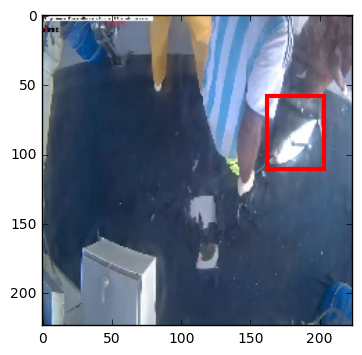

In [159]:
show_bb(0)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image.  
To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates.  
We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [168]:
p=0.6

In [169]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [170]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [266]:
model

In [171]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 3s - loss: 5.6262 - bb_loss: 4498.1741 - class_loss: 1.1281 - bb_acc: 0.4056 - class_acc: 0.6717 - val_loss: 4.3637 - val_bb_loss: 3824.5749 - val_class_loss: 0.5391 - val_bb_acc: 0.4760 - val_class_acc: 0.8740
Epoch 2/3
3277/3277 [==============================] - 3s - loss: 4.2602 - bb_loss: 3884.7179 - class_loss: 0.3755 - bb_acc: 0.4864 - class_acc: 0.8877 - val_loss: 3.2688 - val_bb_loss: 3006.7688 - val_class_loss: 0.2620 - val_bb_acc: 0.5120 - val_class_acc: 0.9480
Epoch 3/3
3277/3277 [==============================] - 3s - loss: 2.9101 - bb_loss: 2709.7082 - class_loss: 0.2004 - bb_acc: 0.5398 - class_acc: 0.9417 - val_loss: 2.0343 - val_bb_loss: 1845.6611 - val_class_loss: 0.1886 - val_bb_acc: 0.5960 - val_class_acc: 0.9580


In [172]:
model.optimizer.lr = 1e-5

In [173]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 3s - loss: 1.5754 - bb_loss: 1455.9682 - class_loss: 0.1194 - bb_acc: 0.6112 - class_acc: 0.9612 - val_loss: 1.1755 - val_bb_loss: 982.6991 - val_class_loss: 0.1928 - val_bb_acc: 0.6520 - val_class_acc: 0.9560
Epoch 2/10
3277/3277 [==============================] - 3s - loss: 0.7985 - bb_loss: 712.7752 - class_loss: 0.0858 - bb_acc: 0.6765 - class_acc: 0.9707 - val_loss: 0.5949 - val_bb_loss: 459.6363 - val_class_loss: 0.1353 - val_bb_acc: 0.6800 - val_class_acc: 0.9640
Epoch 3/10
3277/3277 [==============================] - 3s - loss: 0.5013 - bb_loss: 434.5388 - class_loss: 0.0668 - bb_acc: 0.6991 - class_acc: 0.9792 - val_loss: 0.5828 - val_bb_loss: 369.1395 - val_class_loss: 0.2137 - val_bb_acc: 0.7260 - val_class_acc: 0.9540
Epoch 4/10
3277/3277 [==============================] - 3s - loss: 0.4294 - bb_loss: 366.4524 - class_loss: 0.0630 - bb_acc: 0.7046 - class_acc: 0.9811 - val

Excitingly, it turned out that the classification model is much improved by giving it this additional task.  
Let's see how well the bounding box model did by taking a look at its output.

In [180]:
pred = model.predict(conv_val_feat[0:10])

In [181]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky for us to see!

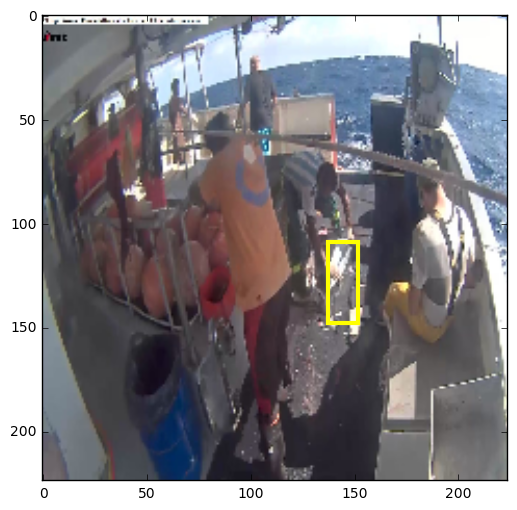

In [182]:
show_bb_pred(6)

In [183]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

416/500 [=======================>......] - ETA: 0s

[0.41784129202365877,
 267.54402868652346,
 0.15029724709875883,
 0.7140000004768372,
 0.97599999999999998]

In [184]:
model.save_weights(path+'models/bn_anno.h5')

In [185]:
model.load_weights(path+'models/bn_anno.h5')

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [186]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


The image shows that things are much clearer at this size.

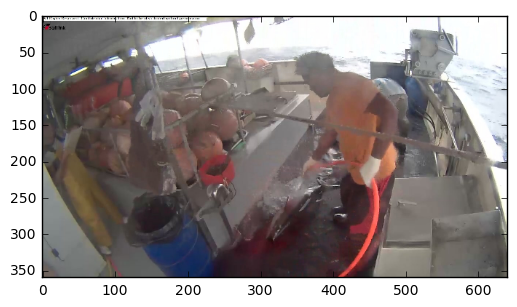

In [187]:
plot(trn[0])

In [188]:
test = get_data(path+'test', (360,640))

Found 1000 images belonging to 1 classes.


In [189]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [190]:
save_array(path+'results/test_640.dat', test)

In [191]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images,   
which also means it won't include the fully connected layers (since they don't make sense for non-default sizes).  
We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [193]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

We can now pre-compute the output of the convolutional part of VGG.  
Same as was above.. but with the larger images

In [194]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

3277/3277 [==============================] - 392s   


In [195]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [196]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 119s   


In [197]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [198]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [199]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger.   
So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN);   
this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem  
(since the fish are a small part of the image).

In [200]:
conv_layers,_ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [201]:
nf=128; p=0.

In [202]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [203]:
lrg_model = Sequential(get_lrg_layers())

In [204]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_15 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_53 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_15[0][0]      
____________________________________________________________________________________________________
batchnormalization_16 (BatchNorm (None, 128, 22, 40)   512         convolution2d_53[0][0]           
____________________________________________________________________________________________________
maxpooling2d_24 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_16[0][0]      
___________________________________________________________________________________________

In [205]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [206]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 15s - loss: 0.6607 - acc: 0.7983 - val_loss: 0.7825 - val_acc: 0.7380
Epoch 2/2
3277/3277 [==============================] - 15s - loss: 0.1849 - acc: 0.9487 - val_loss: 0.2858 - val_acc: 0.9100


In [207]:
lrg_model.optimizer.lr=1e-5

In [208]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 15s - loss: 0.0890 - acc: 0.9744 - val_loss: 0.3002 - val_acc: 0.9120
Epoch 2/6
3277/3277 [==============================] - 15s - loss: 0.0674 - acc: 0.9829 - val_loss: 0.2092 - val_acc: 0.9460
Epoch 3/6
3277/3277 [==============================] - 15s - loss: 0.0237 - acc: 0.9957 - val_loss: 0.2059 - val_acc: 0.9560
Epoch 4/6
3277/3277 [==============================] - 15s - loss: 0.0182 - acc: 0.9954 - val_loss: 0.1931 - val_acc: 0.9540
Epoch 5/6
3277/3277 [==============================] - 15s - loss: 0.0677 - acc: 0.9805 - val_loss: 0.3117 - val_acc: 0.9340
Epoch 6/6
3277/3277 [==============================] - 15s - loss: 0.0352 - acc: 0.9881 - val_loss: 0.2881 - val_acc: 0.9400


An even smaller LR .. takes almost the smae time per epoch  
More epochs for better accuracy

Jeremy:: When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

I didn't submit yet :P

In [209]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [210]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

In [211]:
lrg_model.evaluate(conv_val_feat, val_labels)

480/500 [===========================>..] - ETA: 0s

[0.28808766205608843, 0.93999999952316282]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after).   
Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [212]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [213]:
def get_cm(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [214]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

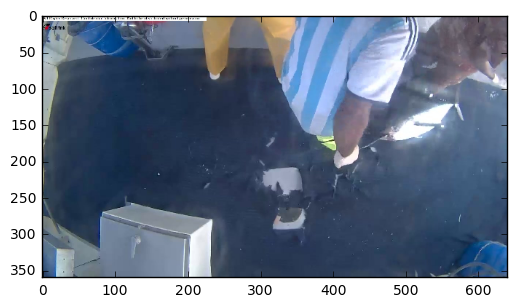

In [215]:
plt.imshow(to_plot(val[0]))

In [216]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!  
Rony: And I cant even identify the fish (to the right of the guy with messi like shirt.. any others..?)

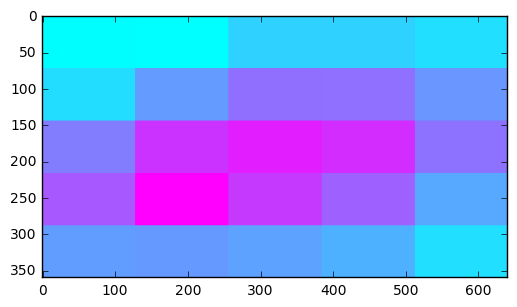

In [217]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers (cos maxpooling basically lowers the resolution.. max of a pool of pixels), and repeat the previous steps.

In [218]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [219]:
lrg_model = Sequential(get_lrg_layers())

In [220]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_19 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_57 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_19[0][0]      
____________________________________________________________________________________________________
batchnormalization_20 (BatchNorm (None, 128, 22, 40)   512         convolution2d_57[0][0]           
____________________________________________________________________________________________________
convolution2d_58 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_20[0][0]      
___________________________________________________________________________________________

In [221]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [222]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 20s - loss: 0.9018 - acc: 0.7357 - val_loss: 0.6984 - val_acc: 0.8320
Epoch 2/2
3277/3277 [==============================] - 20s - loss: 0.2493 - acc: 0.9332 - val_loss: 0.4225 - val_acc: 0.8840


Retrain cos we removed the max pool layers .. 
remember..?

In [223]:
lrg_model.optimizer.lr=1e-5

In [224]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 20s - loss: 0.1331 - acc: 0.9609 - val_loss: 0.3745 - val_acc: 0.9100
Epoch 2/6
3277/3277 [==============================] - 20s - loss: 0.0782 - acc: 0.9774 - val_loss: 0.2242 - val_acc: 0.9460
Epoch 3/6
3277/3277 [==============================] - 20s - loss: 0.0762 - acc: 0.9765 - val_loss: 0.1784 - val_acc: 0.9480
Epoch 4/6
3277/3277 [==============================] - 20s - loss: 0.0366 - acc: 0.9887 - val_loss: 0.2158 - val_acc: 0.9420
Epoch 5/6
3277/3277 [==============================] - 20s - loss: 0.0215 - acc: 0.9942 - val_loss: 0.1621 - val_acc: 0.9680
Epoch 6/6
3277/3277 [==============================] - 20s - loss: 0.0109 - acc: 0.9979 - val_loss: 0.1973 - val_acc: 0.9640


In [225]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [226]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap

In [227]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

What was the 4th last layer above.. is now the 3rd

In [228]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [229]:
inp = np.expand_dims(conv_val_feat[0], 0)

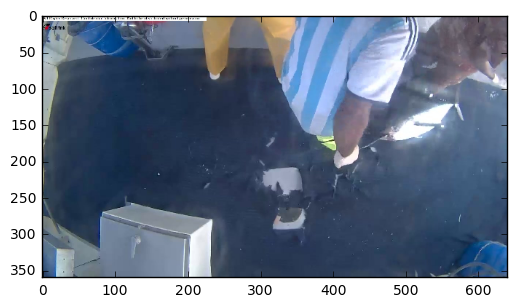

In [230]:
plt.imshow(to_plot(val[0]))

In [231]:
cm = get_cm2(inp, 0)

In [232]:
cm = get_cm2(inp, 4)

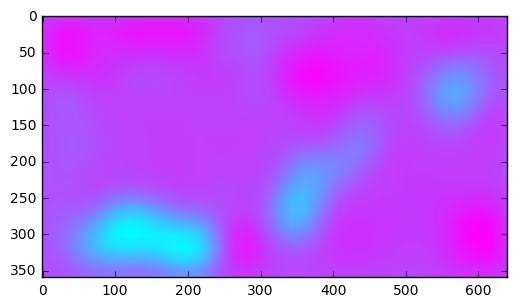

In [233]:
plt.imshow(cm, cmap="cool")

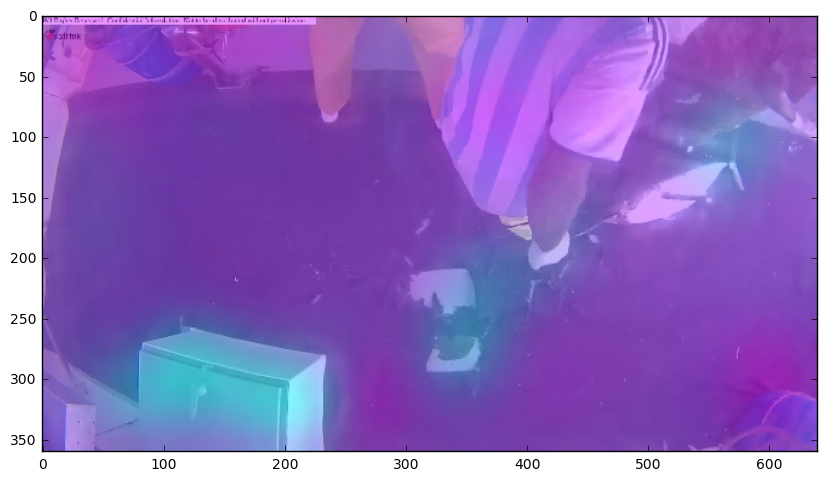

In [234]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

Seems to focus on what is important.. :)  
Humans aren't.. focus on boart parts..   
may stem from the system trying to associalte a certain type of fish to acertain type of boat..  
the boat being identitfied by the part..?

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [235]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [236]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [237]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [238]:
lrg_model = Model([inp], outp)

In [239]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [240]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 21s - loss: 1.1565 - acc: 0.6073 - val_loss: 1.1441 - val_acc: 0.8120
Epoch 2/2
3277/3277 [==============================] - 21s - loss: 0.3489 - acc: 0.8987 - val_loss: 0.3488 - val_acc: 0.9220


In [241]:
lrg_model.optimizer.lr=1e-5

In [242]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 21s - loss: 0.1576 - acc: 0.9567 - val_loss: 0.2833 - val_acc: 0.9440
Epoch 2/6
3277/3277 [==============================] - 21s - loss: 0.0720 - acc: 0.9780 - val_loss: 0.2808 - val_acc: 0.9340
Epoch 3/6
3277/3277 [==============================] - 21s - loss: 0.0418 - acc: 0.9930 - val_loss: 0.2525 - val_acc: 0.9460
Epoch 4/6
3277/3277 [==============================] - 21s - loss: 0.1313 - acc: 0.9616 - val_loss: 0.3918 - val_acc: 0.9200
Epoch 5/6
3277/3277 [==============================] - 21s - loss: 0.0496 - acc: 0.9832 - val_loss: 0.2666 - val_acc: 0.9380
Epoch 6/6
3277/3277 [==============================] - 22s - loss: 0.0240 - acc: 0.9930 - val_loss: 0.2556 - val_acc: 0.9580


In [243]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 22s - loss: 0.0193 - acc: 0.9951 - val_loss: 0.2953 - val_acc: 0.9420
Epoch 2/10
3277/3277 [==============================] - 21s - loss: 0.1200 - acc: 0.9603 - val_loss: 0.3875 - val_acc: 0.9160
Epoch 3/10
3277/3277 [==============================] - 22s - loss: 0.0695 - acc: 0.9771 - val_loss: 0.2793 - val_acc: 0.9540
Epoch 4/10
3277/3277 [==============================] - 22s - loss: 0.0323 - acc: 0.9927 - val_loss: 0.2200 - val_acc: 0.9600
Epoch 5/10
3277/3277 [==============================] - 22s - loss: 0.0171 - acc: 0.9939 - val_loss: 0.2097 - val_acc: 0.9540
Epoch 6/10
3277/3277 [==============================] - 22s - loss: 0.0142 - acc: 0.9963 - val_loss: 0.2409 - val_acc: 0.9520
Epoch 7/10
3277/3277 [==============================] - 21s - loss: 0.0441 - acc: 0.9854 - val_loss: 0.2531 - val_acc: 0.9520
Epoch 8/10
3277/3277 [==============================] - 21s - loss: 0.0

In [244]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [245]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

## Pseudo-labeling

 we want to use the metadata: Source[http://forums.fast.ai/t/lesson-7-discussion/252/14]
 But then: like jeremy pointed out: not sure about how the admins categories the tesst set into various categories :P

In [262]:
#raw_test_sizes = [PIL.Image.open(path+'test/'+f).size for f in val_filenames]
#test_sizes = to_categorical([size2id[o] for o in raw_test_sizes], len(id2size))
#test_sizes = test_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [256]:
lrg_model

In [255]:
model

In [267]:
#preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)
#preds = model.predict(conv_test_feat, batch_size=batch_size*2)
preds = lrg_model.predict(conv_test_feat, batch_size=batch_size*2)

ValueError: Error when checking : expected input_3 to have shape (None, 512, 14, 14) but got array with shape (1000, 512, 22, 40)

So it is neither the model .. nor the large model

In [258]:
gen = image.ImageDataGenerator()

In [259]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

ValueError: NumpyArrayIterator is set to use the dimension ordering convention "th" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (1000, 512, 22, 40) (512 channels).

In [265]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

ValueError: NumpyArrayIterator is set to use the dimension ordering convention "th" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (500, 512, 22, 40) (512 channels).

In [ ]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [253]:
mi = MixIterator([batches, test_batches, val_batches])

NameError: name 'test_batches' is not defined

In [ ]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

## Submit

In [247]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [248]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.2848840107517317, 0.95599999618530274]

In [249]:
preds = model.predict(conv_test_feat, batch_size=batch_size)

ValueError: Error when checking : expected input_3 to have shape (None, 512, 14, 14) but got array with shape (1000, 512, 22, 40)

In [ ]:
preds = preds[1]

In [ ]:
test = load_array(path+'results/test_640.dat')

In [ ]:
test = load_array(path+'results/test.dat')

In [ ]:
preds = conv_model.predict(test, batch_size=32)

In [ ]:
subm = do_clip(preds,0.82)

In [ ]:
subm_name = path+'results/subm_bb.gz'

In [ ]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [ ]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

In [ ]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [ ]:
FileLink(subm_name)